<a href="https://colab.research.google.com/github/andrew-ryabchenko/DS-Unit-2-Kaggle-Challenge/blob/master/LS_DS_221_guided_project(Nicholas_Lecture).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Decision Trees

- clean data with **outliers and missing values**
- use scikit-learn **pipelines**
- use scikit-learn for **decision trees**
- get and interpret **feature importances** of a tree-based model
- understand why decision trees are useful to model 

In [1]:
%%capture

import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/master/data/'
    !pip install category_encoders==2.*
    !pip install pandas-profiling==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

# I. Wrangle Data

## Import Data

In [2]:
import pandas as pd

train = pd.merge(pd.read_csv(DATA_PATH+'waterpumps/train_features.csv', na_values=[0, -2.000000e-08]), 
                 pd.read_csv(DATA_PATH+'waterpumps/train_labels.csv'))


In [3]:
def wrangle(X):
  # Make a copy
  X = X.copy()
  X.set_index('id', inplace=True)
  X['date_recorded'] = pd.to_datetime(X['date_recorded']).dt.year


  # Drop constant values
  X.drop(columns='recorded_by', inplace=True)

  # Drop repeated columns
  X.drop(columns=['quantity_group', 'extraction_type_group'], inplace = True)

  # Eliminate high_cardinality categorical features
  hc_cols = [col for col in X.select_dtypes('object').columns if X[col].nunique() > 100]
  X.drop(columns = hc_cols, inplace=True)

  return X

In [4]:
train = wrangle(train)

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 59399 entries, 69572.0 to 26348.0
Data columns (total 30 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   amount_tsh             17761 non-null  float64
 1   date_recorded          59399 non-null  int64  
 2   gps_height             38962 non-null  float64
 3   longitude              57587 non-null  float64
 4   latitude               57587 non-null  float64
 5   num_private            757 non-null    float64
 6   basin                  59399 non-null  object 
 7   region                 59399 non-null  object 
 8   region_code            59399 non-null  int64  
 9   district_code          59376 non-null  float64
 10  population             38019 non-null  float64
 11  public_meeting         56066 non-null  object 
 12  scheme_management      55522 non-null  object 
 13  permit                 56343 non-null  object 
 14  construction_year      38691 non-null  float

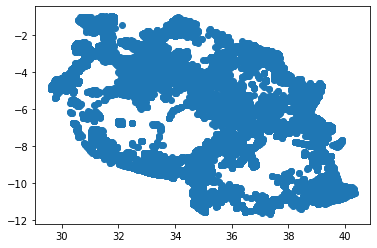

In [8]:
import matplotlib.pyplot as plt

plt.scatter(train['longitude'], train['latitude'])
plt.show()

### Problems we need to fix with our wrangle function
> * Null Island
* High-cardinality features
* *quantity_group* as a repeat

In [ ]:
from pandas_profiling import ProfileReport

ProfileReport(train, minimal = True)

# II. Split Data

## Split TV from FM

In [10]:
target = 'status_group'
y = train[target]
X = train.drop(columns=target)

## Training-Validation Split

In [11]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [12]:
assert len(X_train) + len(X_val) == len(X)

# III. Establish Baseline

This is a **classification** problem, our baseline will be **accuracy**. 

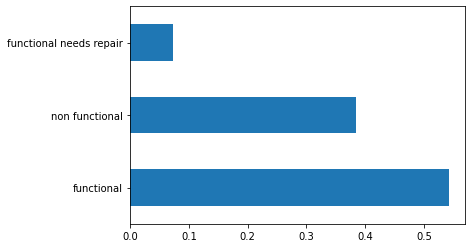

In [13]:
y_train.value_counts(normalize=True).plot(kind='barh')

In [14]:
print('Baseline Accuracy:', y_train.value_counts(normalize=True).max())

Baseline Accuracy: 0.5425829668132747


# IV. Build Model(s)

In [15]:
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from category_encoders import OneHotEncoder, OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### **First Model**: Logistic Regression

In [16]:
model_lr = make_pipeline(
    OneHotEncoder(use_cat_names=True),
    SimpleImputer(),
    StandardScaler(),
    LogisticRegression()
)
model_lr.fit(X_train,y_train)
# Fix datetime

/usr/local/lib/python3.6/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Pipeline(memory=None,
         steps=[('onehotencoder',
                 OneHotEncoder(cols=['basin', 'region', 'public_meeting',
                                     'scheme_management', 'permit',
                                     'extraction_type', 'extraction_type_class',
                                     'management', 'management_group',
                                     'payment', 'payment_type', 'water_quality',
                                     'quality_group', 'quantity', 'source',
                                     'source_type', 'source_class',
                                     'waterpoint_type',
                                     'waterpoint_type_group']...
                               verbose=0)),
                ('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('logisticregression',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    

In [22]:
model_dt = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    DecisionTreeClassifier(random_state=42)
)
model_dt.fit(X_train,y_train)
# Fix datetime

Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['basin', 'region', 'public_meeting',
                                      'scheme_management', 'permit',
                                      'extraction_type',
                                      'extraction_type_class', 'management',
                                      'management_group', 'payment',
                                      'payment_type', 'water_quality',
                                      'quality_group', 'quantity', 'source',
                                      'source_type', 'source_class',
                                      'waterpoint_type',
                                      'waterpoint_type_group...
                               verbose=0)),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                        criterion='gini', max_depth=None,
                       

# V. Check Metrics

In [ ]:
print('LOG: Training Accuracy', model_lr.score(X_train, y_train))
print('LOG: Validation Accuracy', model_lr.score(X_val,y_val))

In [ ]:
print('DT: Training Accuracy', model_dt.score(X_train, y_train))
print('DT: Validation Accuracy', model_dt.score(X_val,y_val))

In [18]:
model_dt.named_steps['decisiontreeclassifier'].get_depth()

38

In [ ]:
import graphviz
from sklearn.tree import export_graphviz

dot_data = export_graphviz(model_dt.named_steps['decisiontreeclassifier'],
                           feature_names = X_train.columns,
                           impurity=False,
                           filled = True,
                           max_depth = 5
                           )
display(graphviz.Source(dot_data))

# Interlude: How does a tree model work?

# VI. Communicate Results

# Interlude: What is overfitting?

- Let's look at the hyperparameter `max_depth`